In [32]:
MAIN_SPORT_DOCUMENT_FILE_PATH = 'SPORT_documents//sport_ttc_20220814.ods'

from CatalogDataReader import CatalogDataReader

catalog_data = CatalogDataReader()

main_tm_df = catalog_data.get_all_tms_on_the_document(MAIN_SPORT_DOCUMENT_FILE_PATH)
main_dd_df = catalog_data.get_all_dds_from_document(MAIN_SPORT_DOCUMENT_FILE_PATH)

In [176]:
from TelemetryDataReader import TelemetryDataReader

telemetry_reader = TelemetryDataReader()

telemetry_file_path = 'decoded_satcs_dump\\adcs_housekeeping_only.out'
df = telemetry_reader.get_space_packets_df_from_file(telemetry_file_path)
df

,version_number,pkt_type,sec_hdr_flag,apid,seq_flags,seq_count,pkt_data_length,secondary_header,data,checksum
0,0,0,1,0x14,0x3,00000000000000,0x6d,2023-09-27 11:28:49.968,0000000111001111100000110001111100000000000000...,1000110101101011
1,0,0,1,0x32,0x3,00000000000001,0x8f,2023-09-27 11:28:49.968,0000000000000000000000000000000000000000000000...,1100011111001110
2,0,0,0,0x15,0x1,00000000000000,0xe4,NaT,0000000000000000000010001110100100010001111010...,0010100110111000
3,0,0,0,0x15,0x2,00000000000001,0x39,NaT,0000000000000000000000000000000000000000000000...,1000010110101000
4,0,0,0,0x33,0x1,00000000000000,0xe4,NaT,0000000000000000000010001110100100010001111010...,0100111011001010
...,...,...,...,...,...,...,...,...,...,...
324,0,0,1,0x14,0x3,00000001111100,0x6d,2023-09-27 11:33:59.970,0000000111010100001111100000111100000000000000...,1110000110000011
325,0,0,1,0x32,0x3,00000001111101,0x8f,2023-09-27 11:33:59.970,0000000000000000000000000000000000000000000000...,0101001000100010
326,0,0,0,0x15,0x1,00000000000000,0xe4,NaT,0000000000000000000010001110100100010001111011...,1101100101110010
327,0,0,0,0x15,0x2,00000000000001,0x39,NaT,0000000000000000000000000000000000000000000000...,0100111100000101


In [177]:

import pandas as pd
import copy
import struct

from DataConverter import DataConverter

data_converter = DataConverter()

def binary_to_value(binary_str, data_type):
    if binary_str == '':
            return None
    
    if data_type == 'uint8':
        return int(binary_str, 2)
    elif data_type == 'uint16':
        return int(binary_str, 2)
    elif data_type == 'uint32':
        return int(binary_str, 2)
    elif data_type == 'int16':
        return int(binary_str, 2) if binary_str[0] == '0' else int(binary_str, 2) - (1 << 16)
    elif data_type == 'int32':
        return int(binary_str, 2) if binary_str[0] == '0' else int(binary_str, 2) - (1 << 32)
    elif data_type == 'float':
        return struct.unpack('!f', struct.pack('!I', int(binary_str, 2)))[0]
    elif data_type == 'vector6':
        return [struct.unpack('!f', struct.pack('!I', int(binary_str[i:i+32], 2)))[0] for i in range(0, len(binary_str), 32)]
    elif data_type == 'quaternion':
        return [struct.unpack('!f', struct.pack('!I', int(binary_str[i:i+32], 2)))[0] for i in range(0, len(binary_str), 32)]
    elif data_type == 'char':
        return chr(int(binary_str, 2))
    elif data_type == 'vector3':
        return [struct.unpack('!f', struct.pack('!I', int(binary_str[i:i+32], 2)))[0] for i in range(0, len(binary_str), 32)]
    elif data_type == 'bit':
        return int(binary_str)
    elif data_type == 'GPS time':
        return data_converter.convert_64bit_binary_to_datetime(binary_str)
    else:
        raise ValueError("Unsupported data type")

formats_to_implement = []

def calculate_data_conversion(apid:str, binary_data: int, main_dd_df: pd.DataFrame):

    new_data_packets = copy.deepcopy(main_dd_df.query(f"""apid == '{apid}'""")['data_packets'].item())
    pointer = 0
    for single_data_field in new_data_packets:
        bit_length = single_data_field['lenght(bits)']
        if (bit_length is None) or (bit_length == 'N/A'):
            bit_length = 0
        elif bit_length >= len(binary_data):
            break
        else:
            bit_length = int(bit_length)
        
        binary_slice = binary_data[pointer:(pointer+bit_length)]
        data_format = single_data_field['format']

        if data_format == '12-bit ADC':
            input_16bit = int(binary_slice, 2)
            # Use mask to extract the 12-bit ADC value from the 16-bit input (lower 12 bits)
            adc_value = input_16bit & 0x0FFF
            conversion_formula = single_data_field['conversion']
            conversion_formula = conversion_formula.replace("^", "**").replace("–", "-")
            conversion_formula = conversion_formula.replace("adc", str(adc_value))
            transformed_value = eval(conversion_formula)
        elif data_format == '10-bit ADC':
            input_16bit = int(binary_slice, 2)
            adc_value = input_16bit & 0x03FF
            conversion_formula = single_data_field['conversion']
            conversion_formula = conversion_formula.replace("^", "**").replace("–", "-")
            conversion_formula = conversion_formula.replace("adc", str(adc_value))
            transformed_value = eval(conversion_formula)
        elif data_format is None:
            transformed_value = None
        else:
            try:
                transformed_value = binary_to_value(binary_slice, data_format)
            except ValueError:
                print(f"Implement this format: {data_format} - {binary_slice}")
                if data_format not in formats_to_implement:
                    formats_to_implement.append(data_format)
                transformed_value = None

        single_data_field['value'] = transformed_value
        pointer += bit_length

    return new_data_packets

new_fields = []
for i in range(0, len(df)):
    apid = df.iloc[i,:]['apid']
    binary_data = df.iloc[i,:]['data']

    new_fields.append(calculate_data_conversion(apid,binary_data, main_dd_df))

df['data_transformed'] = new_fields

df

Implement this format: css - 0000000000000000000000000011111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Implement this format: uchar - 00000000
Implement this format: matrix34 - 010000100010100100001100101000111100001000100000000000000000000010111111000000000000000000000000101111110000000000000000000000001011111100000000000000000000000010111111000000000000000000000000000000000000000000000000000000000011111101011101101100111101000000000000000000000000000000000000101111110101110110110011110100000011111101011101101100111101000000000000000000000000000000000000
Implement this format: matrix43 - 10111111010111011011001111010000000000000000000000000000000000001011111100000000000000000000000000000000000000000000000000000000001111110001001111001101001111111011111100000000000000000000000000111111000100111100110100111

,version_number,pkt_type,sec_hdr_flag,apid,seq_flags,seq_count,pkt_data_length,secondary_header,data,checksum,data_transformed
0,0,0,1,0x14,0x3,00000000000000,0x6d,2023-09-27 11:28:49.968,0000000111001111100000110001111100000000000000...,1000110101101011,"[{'field': 'CurrentTimer', 'lenght(bits)': 32...."
1,0,0,1,0x32,0x3,00000000000001,0x8f,2023-09-27 11:28:49.968,0000000000000000000000000000000000000000000000...,1100011111001110,"[{'field': 'Gyr0Sts', 'lenght(bits)': 16.0, 'f..."
2,0,0,0,0x15,0x1,00000000000000,0xe4,NaT,0000000000000000000010001110100100010001111010...,0010100110111000,"[{'field': 'sgp4_state_vec()', 'lenght(bits)':..."
3,0,0,0,0x15,0x2,00000000000001,0x39,NaT,0000000000000000000000000000000000000000000000...,1000010110101000,"[{'field': 'sgp4_state_vec()', 'lenght(bits)':..."
4,0,0,0,0x33,0x1,00000000000000,0xe4,NaT,0000000000000000000010001110100100010001111010...,0100111011001010,"[{'field': 'sgp4_kep()', 'lenght(bits)': 192.0..."
...,...,...,...,...,...,...,...,...,...,...,...
324,0,0,1,0x14,0x3,00000001111100,0x6d,2023-09-27 11:33:59.970,0000000111010100001111100000111100000000000000...,1110000110000011,"[{'field': 'CurrentTimer', 'lenght(bits)': 32...."
325,0,0,1,0x32,0x3,00000001111101,0x8f,2023-09-27 11:33:59.970,0000000000000000000000000000000000000000000000...,0101001000100010,"[{'field': 'Gyr0Sts', 'lenght(bits)': 16.0, 'f..."
326,0,0,0,0x15,0x1,00000000000000,0xe4,NaT,0000000000000000000010001110100100010001111011...,1101100101110010,"[{'field': 'sgp4_state_vec()', 'lenght(bits)':..."
327,0,0,0,0x15,0x2,00000000000001,0x39,NaT,0000000000000000000000000000000000000000000000...,0100111100000101,"[{'field': 'sgp4_state_vec()', 'lenght(bits)':..."


None


<Axes: xlabel='time'>

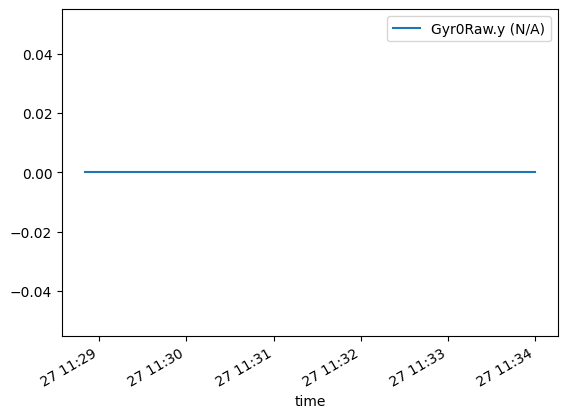

In [182]:
y = []
field_id = 3

teste_df = df.query("""apid == '0x32'""")

for i in range(0, len(teste_df)):
    field_data = (teste_df.iloc[i, :]['data_transformed'])[field_id]
    field_name = field_data['field']
    field_unit = field_data['unit']
    observation = field_data['observation']
    y.append(field_data['value'])

new_df = teste_df['secondary_header'].reset_index().copy()
print(observation)
new_df[f"{field_name} ({field_unit})"] = y
new_df = new_df.rename(columns={'secondary_header':'time'})
new_df = new_df.drop(columns='index').set_index('time')
new_df.loc['2023-01-01':].plot()